# Modelling - RNNs, LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from typing import Dict

from keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, LSTM

In [2]:
raw_data = pd.read_csv('assets/total_data.csv')
raw_data.head()

,month,mean_temp,rainfall,dengue_cases
0,2012-01-01,26.7,106.1,338
1,2012-02-01,27.2,83.6,258
2,2012-03-01,27.0,313.4,231
3,2012-04-01,27.6,260.6,363
4,2012-05-01,28.2,292.0,338


## Utility functions:

1. Function to preprocess data

In [37]:
def preprocessor(raw_data: Dict, look_back: int):
    """
    Input: raw data (dataframe), look_back (int)\
    Output: X_train, X_test, y_train, y_test
    """
    dengue_cases = raw_data['dengue_cases'].values.reshape(-1, 1)

    # Apply log transformation to scale data
    dengue_cases = np.log1p(dengue_cases)

    X, y = [], []

    # Create the input and output data
    for i in range(len(dengue_cases) - look_back - 1):
        X.append(dengue_cases[i:(i + look_back), 0])
        y.append(dengue_cases[i + look_back, 0])

    # Convert the input and output data to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Split data into training and test sets (80/20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_test, y_train, y_test

2. Function to preprocess multivariate time series with additional features - rainfall and mean temp

In [38]:
def multi_feature_preprocessor(raw_data: Dict, look_back: int):
    data = raw_data[['mean_temp', 'rainfall', 'dengue_cases']].values

    # Apply log transformation to scale data
    data = np.log1p(data)

    X, y = [], []

    # Create the input and output data
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back, -1])  # assuming the target is the last column

    # Convert the input and output data to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Split data into training and test sets (80/20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape the data back to 3 dimensions
    X_train = X_train.reshape((X_train.shape[0], look_back, -1))
    X_test = X_test.reshape((X_test.shape[0], look_back, -1))

    return X_train, X_test, y_train, y_test

3. Function to calculate RMSE scores for train and test sets

In [4]:
def calculate_rmse(y_train, y_test, y_train_pred, y_test_pred):
    """
    Input: y_train, y_test, y_train_pred, y_test_pred (numpy arrays)
    Output: rmse_train, rmse_test (float)
    """
    rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))

    return f"Train RMSE score: {rmse_train} and the test RMSE score: {rmse_test}"

4. Function to transform the scaled values back for plotting

In [5]:
def inversing_log_values( array_list):
    """
    Input: array_list (list of numpy arrays to be transformed)
    Output: inversed list of transformed arrays
    """
    inversed_list = [np.expm1(array) for array in array_list]

    return inversed_list

5. Function for a plot of actual vs predicted cases

In [6]:
def plot(y_test_pred, plot_title: str):
    """
    Input: y_test_pred (numpy array)
    Output: None
    """
    
    plt.figure(figsize=(13, 6))
    plt.plot(raw_data['month'], raw_data['dengue_cases'], color='blue', label='Actual Dengue Cases')
    
    # Calculate the starting point for the predictions
    start_point = len(raw_data) - len(y_test_pred)

    plt.plot(raw_data['month'].iloc[start_point:], y_test_pred, color='green', label='Predicted Dengue Cases')
    plt.title(plot_title)

    plt.gca().set_xticks(raw_data['month'][::12])
    plt.xlabel('Time')
    plt.ylabel('Dengue Cases')
    plt.legend()
    plt.show()

## Using 1 feature (dengue cases)

#### RNN model

In [10]:
X_train, X_test, y_train, y_test = preprocessor(raw_data, 5)

In [11]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(4, input_shape=(1, 5)))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

# Train
rnn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Predict
y_train_pred = rnn_model.predict(X_train)
y_test_pred = rnn_model.predict(X_test)

Epoch 1/100
100/100 - 1s - loss: 37.8936 - 1s/epoch - 12ms/step
Epoch 2/100
100/100 - 0s - loss: 15.1168 - 105ms/epoch - 1ms/step
Epoch 3/100
100/100 - 0s - loss: 10.7480 - 100ms/epoch - 1000us/step
Epoch 4/100
100/100 - 0s - loss: 8.6449 - 109ms/epoch - 1ms/step
Epoch 5/100
100/100 - 0s - loss: 6.8758 - 102ms/epoch - 1ms/step
Epoch 6/100
100/100 - 0s - loss: 5.4212 - 101ms/epoch - 1ms/step
Epoch 7/100
100/100 - 0s - loss: 4.2511 - 98ms/epoch - 975us/step
Epoch 8/100
100/100 - 0s - loss: 3.3327 - 103ms/epoch - 1ms/step
Epoch 9/100
100/100 - 0s - loss: 2.6180 - 97ms/epoch - 972us/step
Epoch 10/100
100/100 - 0s - loss: 2.0832 - 100ms/epoch - 999us/step
Epoch 11/100
100/100 - 0s - loss: 1.6883 - 109ms/epoch - 1ms/step
Epoch 12/100
100/100 - 0s - loss: 1.4022 - 108ms/epoch - 1ms/step
Epoch 13/100
100/100 - 0s - loss: 1.2009 - 100ms/epoch - 1ms/step
Epoch 14/100
100/100 - 0s - loss: 1.0654 - 100ms/epoch - 1000us/step
Epoch 15/100
100/100 - 0s - loss: 0.9728 - 100ms/epoch - 1000us/step
Epoch

In [12]:
calculate_rmse(y_train, y_test, y_train_pred, y_test_pred)

'Train RMSE score: 0.507350039686042 and the test RMSE score: 0.5048854659197692'

In [13]:
y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv = inversing_log_values([y_train, y_test, y_train_pred, y_test_pred])

In [14]:
calculate_rmse(y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv)

'Train RMSE score: 913.5282486474522 and the test RMSE score: 1176.0057162878527'

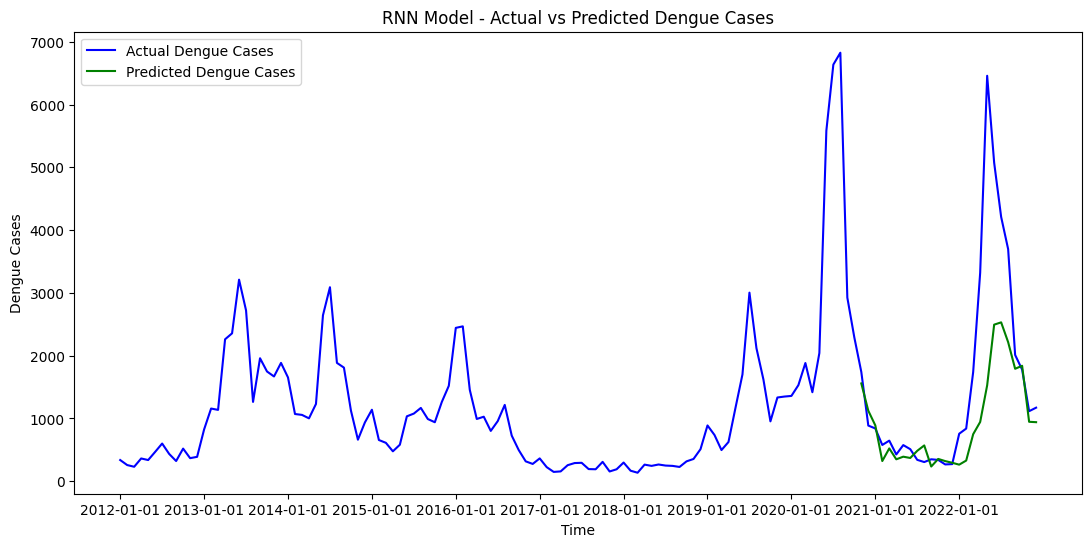

In [16]:
plot(y_test_pred_inv, 'RNN Model - Actual vs Predicted Dengue Cases')

#### LSTM model

In [17]:
X_train, X_test, y_train, y_test = preprocessor(raw_data, 3)

In [18]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, 3)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Epoch 1/100
11/11 - 4s - loss: 43.1955 - 4s/epoch - 376ms/step
Epoch 2/100
11/11 - 0s - loss: 37.7850 - 29ms/epoch - 3ms/step
Epoch 3/100
11/11 - 0s - loss: 29.8914 - 32ms/epoch - 3ms/step
Epoch 4/100
11/11 - 0s - loss: 19.3458 - 31ms/epoch - 3ms/step
Epoch 5/100
11/11 - 0s - loss: 9.1503 - 21ms/epoch - 2ms/step
Epoch 6/100
11/11 - 0s - loss: 3.0105 - 32ms/epoch - 3ms/step
Epoch 7/100
11/11 - 0s - loss: 0.8252 - 31ms/epoch - 3ms/step
Epoch 8/100
11/11 - 0s - loss: 0.5359 - 34ms/epoch - 3ms/step
Epoch 9/100
11/11 - 0s - loss: 0.5976 - 34ms/epoch - 3ms/step
Epoch 10/100
11/11 - 0s - loss: 0.5796 - 34ms/epoch - 3ms/step
Epoch 11/100
11/11 - 0s - loss: 0.5492 - 41ms/epoch - 4ms/step
Epoch 12/100
11/11 - 0s - loss: 0.5349 - 22ms/epoch - 2ms/step
Epoch 13/100
11/11 - 0s - loss: 0.5336 - 39ms/epoch - 4ms/step
Epoch 14/100
11/11 - 0s - loss: 0.5283 - 40ms/epoch - 4ms/step
Epoch 15/100
11/11 - 0s - loss: 0.5242 - 24ms/epoch - 2ms/step
Epoch 16/100
11/11 - 0s - loss: 0.5196 - 32ms/epoch - 3ms/st

In [19]:
calculate_rmse(y_train, y_test, y_train_pred, y_test_pred)

'Train RMSE score: 0.3744738308133912 and the test RMSE score: 0.44027651626471065'

In [20]:
y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv = inversing_log_values([y_train, y_test, y_train_pred, y_test_pred])

In [21]:
calculate_rmse(y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv)

'Train RMSE score: 683.8543180159186 and the test RMSE score: 940.9907253332917'

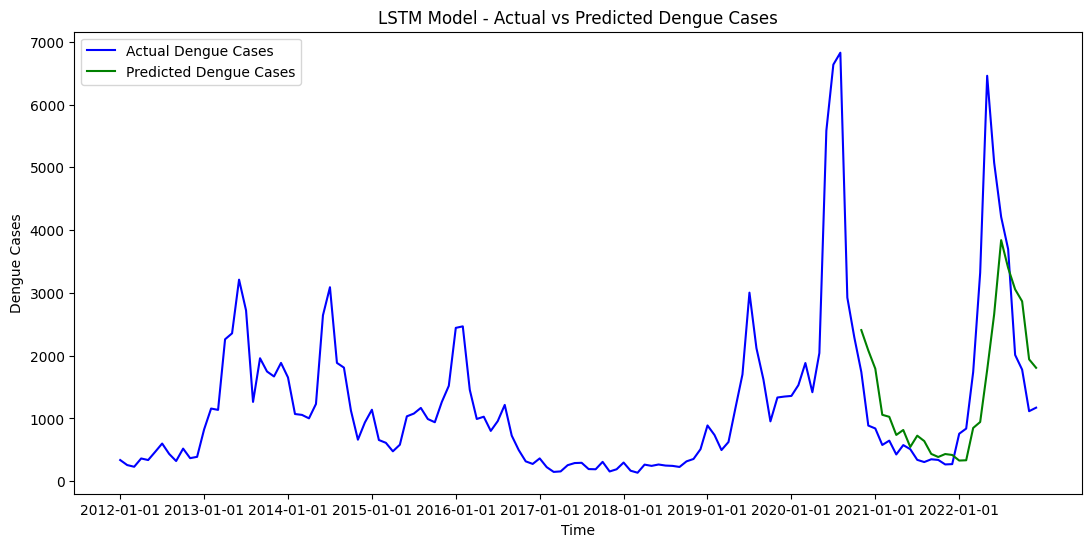

In [22]:
plot(y_test_pred_inv, 'LSTM Model - Actual vs Predicted Dengue Cases')

## Multivariate time series forecasting using additional features (rainfall, mean temperature)

#### RNN multivariate model

In [27]:
X_train, X_test, y_train, y_test = multi_feature_preprocessor(raw_data, 10)

In [28]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(4, input_shape=(10,3)))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

# Train
rnn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Predict
y_train_pred = rnn_model.predict(X_train)
y_test_pred = rnn_model.predict(X_test)

Epoch 1/100
96/96 - 2s - loss: 53.0337 - 2s/epoch - 18ms/step
Epoch 2/100
96/96 - 0s - loss: 45.1501 - 360ms/epoch - 4ms/step
Epoch 3/100
96/96 - 0s - loss: 38.9892 - 270ms/epoch - 3ms/step
Epoch 4/100
96/96 - 0s - loss: 31.1942 - 231ms/epoch - 2ms/step
Epoch 5/100
96/96 - 0s - loss: 25.4106 - 203ms/epoch - 2ms/step
Epoch 6/100
96/96 - 0s - loss: 21.3598 - 217ms/epoch - 2ms/step
Epoch 7/100
96/96 - 0s - loss: 18.0964 - 290ms/epoch - 3ms/step
Epoch 8/100
96/96 - 0s - loss: 15.2677 - 336ms/epoch - 4ms/step
Epoch 9/100
96/96 - 0s - loss: 12.8046 - 276ms/epoch - 3ms/step
Epoch 10/100
96/96 - 0s - loss: 10.6863 - 316ms/epoch - 3ms/step
Epoch 11/100
96/96 - 0s - loss: 8.8685 - 265ms/epoch - 3ms/step
Epoch 12/100
96/96 - 0s - loss: 7.3251 - 243ms/epoch - 3ms/step
Epoch 13/100
96/96 - 0s - loss: 6.0275 - 217ms/epoch - 2ms/step
Epoch 14/100
96/96 - 0s - loss: 4.9473 - 310ms/epoch - 3ms/step
Epoch 15/100
96/96 - 0s - loss: 4.0567 - 218ms/epoch - 2ms/step
Epoch 16/100
96/96 - 0s - loss: 3.3312 - 

In [29]:
calculate_rmse(y_train, y_test, y_train_pred, y_test_pred)

'Train RMSE score: 0.39727405093761275 and the test RMSE score: 0.5335636751631632'

In [30]:
y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv = inversing_log_values( [y_train, y_test, y_train_pred, y_test_pred])

In [31]:
calculate_rmse(y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv)

'Train RMSE score: 771.2164253146395 and the test RMSE score: 1114.1707860243393'

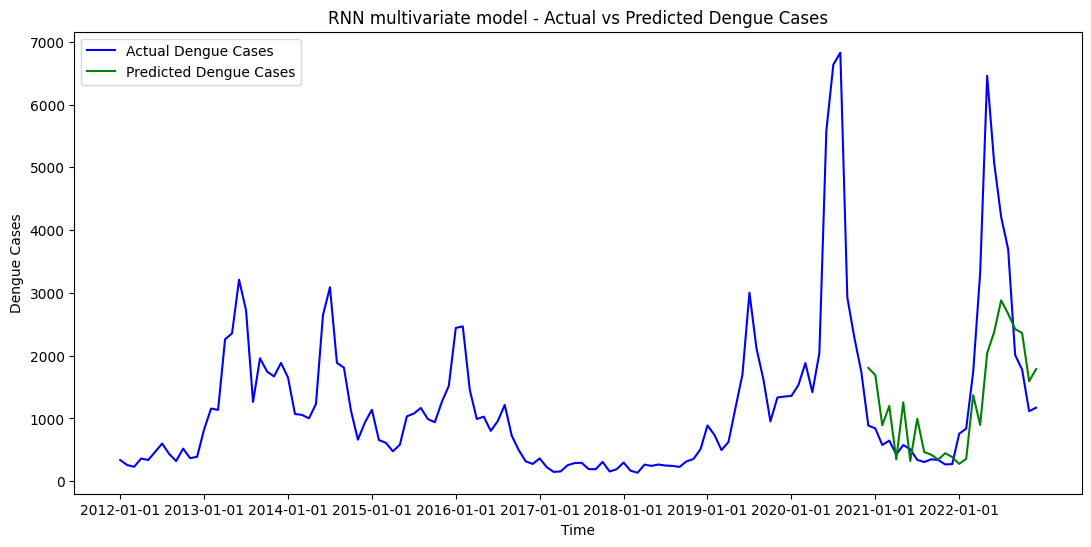

In [32]:
plot(y_test_pred_inv, 'RNN multivariate model - Actual vs Predicted Dengue Cases')

#### LSTM multivariate model

In [39]:
X_train, X_test, y_train, y_test = multi_feature_preprocessor(raw_data, 20)

In [40]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Epoch 1/100
88/88 - 4s - loss: 4.5247 - 4s/epoch - 46ms/step
Epoch 2/100
88/88 - 1s - loss: 0.8355 - 672ms/epoch - 8ms/step
Epoch 3/100
88/88 - 1s - loss: 0.6913 - 700ms/epoch - 8ms/step
Epoch 4/100
88/88 - 1s - loss: 0.4772 - 683ms/epoch - 8ms/step
Epoch 5/100
88/88 - 1s - loss: 0.3156 - 668ms/epoch - 8ms/step
Epoch 6/100
88/88 - 1s - loss: 0.4772 - 661ms/epoch - 8ms/step
Epoch 7/100
88/88 - 1s - loss: 0.2986 - 664ms/epoch - 8ms/step
Epoch 8/100
88/88 - 1s - loss: 0.3405 - 667ms/epoch - 8ms/step
Epoch 9/100
88/88 - 1s - loss: 0.2517 - 670ms/epoch - 8ms/step
Epoch 10/100
88/88 - 1s - loss: 0.2867 - 660ms/epoch - 7ms/step
Epoch 11/100
88/88 - 1s - loss: 0.2728 - 665ms/epoch - 8ms/step
Epoch 12/100
88/88 - 1s - loss: 0.2307 - 662ms/epoch - 8ms/step
Epoch 13/100
88/88 - 1s - loss: 0.2645 - 664ms/epoch - 8ms/step
Epoch 14/100
88/88 - 1s - loss: 0.2554 - 668ms/epoch - 8ms/step
Epoch 15/100
88/88 - 1s - loss: 0.2519 - 654ms/epoch - 7ms/step
Epoch 16/100
88/88 - 1s - loss: 0.2346 - 658ms/epoc

In [41]:
calculate_rmse(y_train, y_test, y_train_pred, y_test_pred)

'Train RMSE score: 0.17175247846905617 and the test RMSE score: 0.7458995156975408'

In [42]:
y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv = inversing_log_values([y_train, y_test, y_train_pred, y_test_pred])

In [43]:
calculate_rmse(y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv)

'Train RMSE score: 309.87905362489573 and the test RMSE score: 1536.341644742151'

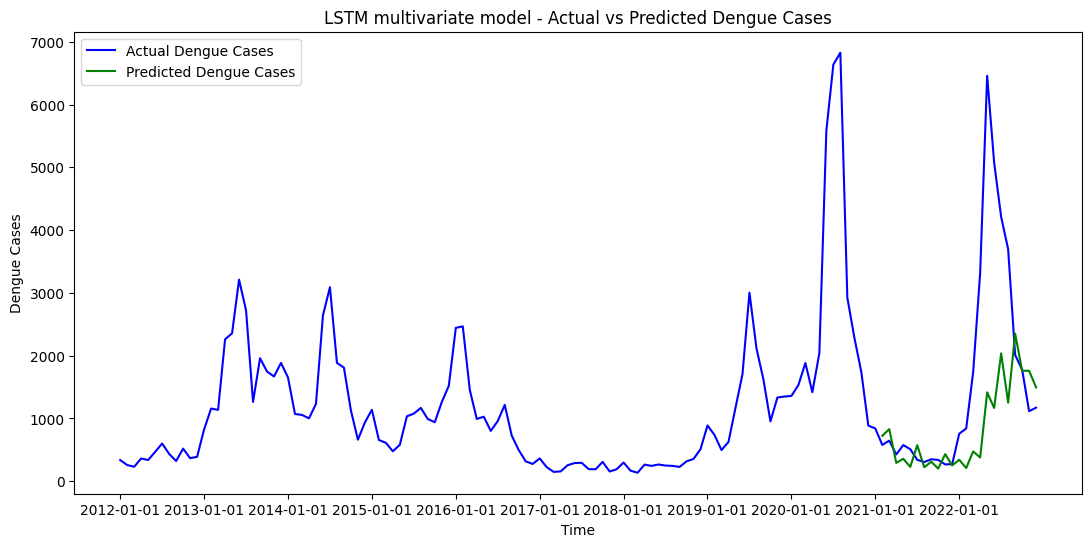

In [44]:
plot(y_test_pred_inv, 'LSTM multivariate model - Actual vs Predicted Dengue Cases')